# **Multilayer Perceptron (MLP)**

In this tutorial, we will solve a *binary classification* problem with a Multilayer Perceptron (MLP) using gradient descent.

We will solve the same problems using three different libraries: *Numpy*, *PyTorch*, and *Scikit learn*.
This way, we can figure out the differences across these popular frameworks.
We are going to use the dataset, model, and objective functions described in the following sections.

## **Dataset**
We have a training set composed of 2-dimensional inputs:
$\mathbf{x}_i = [x_1, x_2]^T$, where $\mathbf{x}_i \in \mathbb{R}^2$.
For convenience, we gather all the inputs into a matrix $\mathbf{X}$:


$\mathbf{X} = \begin{bmatrix}
x_{1,1} & x_{1,2}\\
x_{2,1} & x_{2,2}\\
...  & ...\\
x_{N,1} & x_{N,2}\\
\end{bmatrix}$

For each input $\mathbf{x}_i$, we have a label that can be 0 or 1:

$y_i = \{0,1\}$

Again, we gather all the labels into a vector:

$\mathbf{y} =[y_{1},y_{2},..,y_{i}, ..., y_{N}]^T$, where $\mathbf{y} \in \mathbb{R}^N$.


## **Model**

The MLP model implemented in this lab is the following:

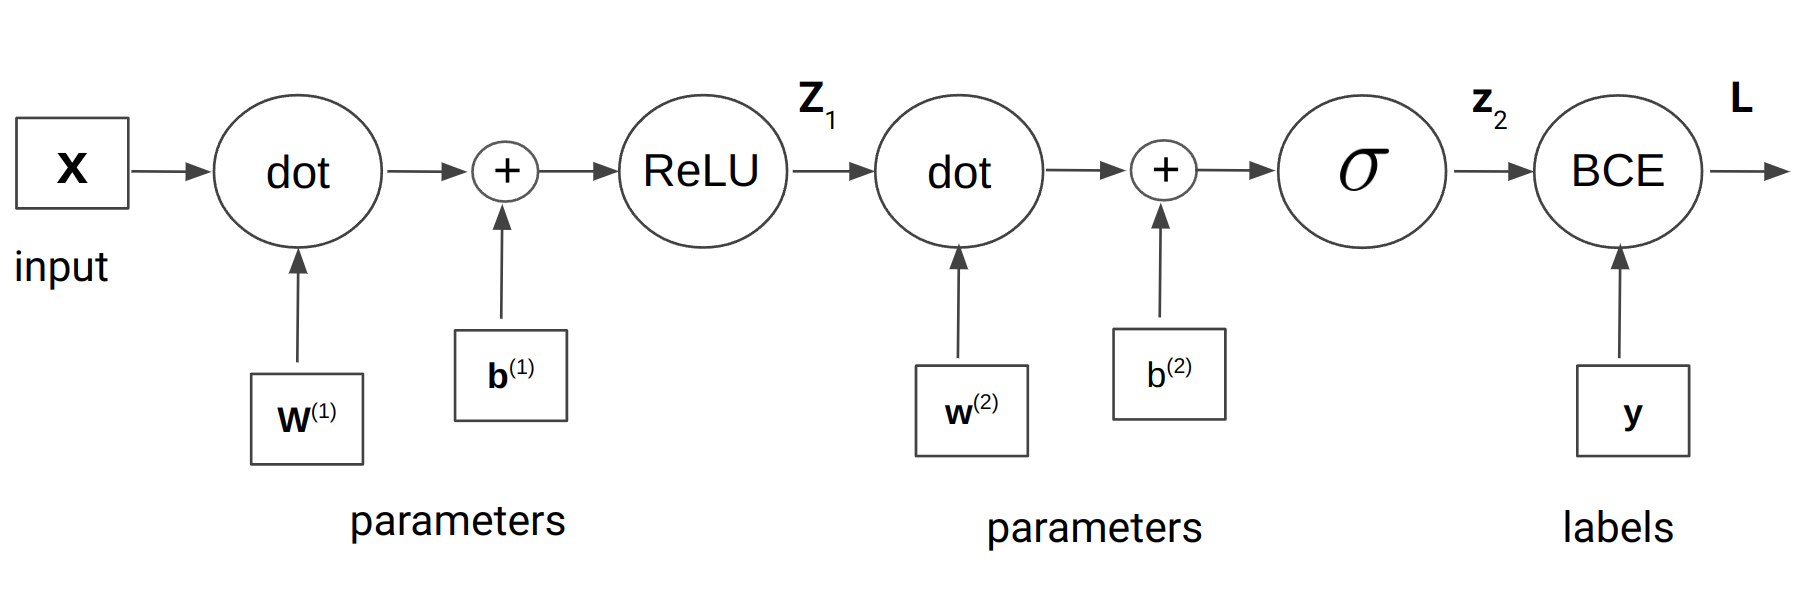

The MLP maps the input vector $\mathbf{x}_i$ into the following scalar output:

$p(y_i = 1 \mid \mathbf{x}_i, \boldsymbol{\theta}) = \sigma\Big(\mathbf{w}^{(2)T} f(\mathbf{W}^{(1)T}\mathbf{x}_i + \mathbf{b}^{(1)}) + b^{(2)}\Big)$

Where $\boldsymbol{\theta} = \{\mathbf{W}^{(1)}, \mathbf{w}^{(2)}, \mathbf{b}^{(2)}, b^{(1)}\}$ are the learnable parameters.

In this case, $\mathbf{W}^{(1)}$ is a $(2 \times 32)$ matrix (32 is the number of hidden neurons), $\mathbf{w}^{(2)}$ is a ($32 \times 1$) weight vector,  $\mathbf{b}^{(1)}$ is a ($32 \times 1$) bias vector, while $b^{(2)}$   is a scalar. The function $f$ is the non-linear activation, which in this tutorial is the ReLU activation:

$ReLU(z) =
\begin{cases}
z \; if \; z < 0 \\
1 \; otherwise
\end{cases}$.


The corresponding vectorized version that gathers in one shot all the N output probabilities for all the datapoints are the following:

$\mathbf{Z}_{1} = ReLU(\mathbf{X}\mathbf{W}^{(1)}+ \mathbf{b}^{(1)})$

$p(\mathbf{y} \mid \mathbf{X}, \boldsymbol{\theta})= \mathbf{z_{2}} = \sigma(\mathbf{Z}_1\mathbf{w}^{(2)}+ \mathbf{b}^{(2)})$

where, $\mathbf{Z}_1$ is a (N, 32) matrix and $\mathbf{z}_2$ is a (N,1) vector.

This is the function implemented in the code because it maximizes parallelization.

Please note that we are employing a version of the MLP equations that differs slightly from the one presented in the slide. In our approach, we remove the bias term **b** from the weight matrix **W**. It's important to understand that both formulations are entirely equivalent. However, in practical implementations, the latter is often preferred because it eliminates the need to concatenate a column of "1" every time in the weight matrices.

## **Objective**
Our goal is to find a configuration of our parameters $\boldsymbol{\theta}$ that minimizes our objective function (BCE).
For logistic regression, we use the binary cross-entropy loss:

$J(\boldsymbol{\theta}) = -\sum_{i=1}^N y_i \ln P(y_i = 1 \mid \mathbf{x}_i, \boldsymbol{\theta}) + (1-y_i) \ln(1- P(y_i = 1 \mid \mathbf{x}_i, \boldsymbol{\theta}))$.

The BCE is low when the output probabilities are close to their corresponding labels.

## **Gradient**
When we will use NumPy, we need to manually compute the gradient. In this case, the gradient equations (derived with backpropagation) are the following:

$\frac{\partial L }{\partial \mathbf{w}_2} = \mathbf{Z}_1^T (\mathbf{z}_2-\mathbf{y})$

$\frac{\partial L }{\partial b_2} = \sum_{i=1}^N(z_{2,i}-y_i)$


$\frac{\partial L }{\partial \mathbf{W}_1} = \mathbf{X}^T \Big( step(\mathbf{Z}_1) * \big((\mathbf{z}_2 - \mathbf{y}) \mathbf{w}_2^T \big)\Big)$

$\frac{\partial L }{\partial \mathbf{b}_1} = \sum_{i=1}^N \Big( step(\mathbf{z}_{1,i}) * \big((z_{2,i} - y_i) \mathbf{w}_2^T \big)\Big)$



# 1. **Dataset Creation**
As a first step, let's create a synthetic dataset. In this case, we sample data from *nested ellipses* (with some noise added to model uncertainty in the observations).

In [ ]:
import math
import numpy as np
import torch
import matplotlib.pyplot as plt


In [ ]:
def elipse_samples(N, u=1, v=0.5, a=2., b=1.5, sigma_noise = 0.3):
  """Draws data from an elipse function (by addding a small noise)

  Arguments:
   N (int): Number of data points to sample
   u (float): x-position of the center
   v (float): y-position of the center
   a (float): radius on the x-axis
   b (float): radius on the y-axis
   sigma_noise: standard deviation applied to the additive noise

  Returns
  x (np.array): samples drawn from the ellipse
  """
  t = np.random.uniform(low=0.0, high=2*math.pi, size=N)
  x1 = u+a*np.cos(t) + np.random.normal(loc=0.0, scale=sigma_noise, size=N)
  x2 =  v+b*np.sin(t) +  np.random.normal(loc=0.0, scale=sigma_noise , size=N)
  return np.stack([x1,x2]).T


def get_dataset(N=100,
                mu0 = np.array([0,0]),
                cov0 = np.array([[0.5,0],[0,0.5]]),
                mu1 = np.array([2,2]),
                cov1 = np.array([[0.5,0],[0,0.5]])):
  """Creates data for binary classification by drawing samples from the ellipse"""

  # Class 0 samples
  x0 = elipse_samples(N, u=0, v=0, a=2., b=1.5)
  y0 = np.zeros(x0.shape[0])

  # Class 1 samples
  x1 = elipse_samples(N, u=0, v=0, a=0.5, b=0.1)
  y1 = np.ones(x1.shape[0])

  X = np.concatenate([x0,x1])
  y = np.concatenate([y0,y1])
  y = np.expand_dims(y,1)
  return X,y

def plot_data(X_train, y_train, xmin=-2.5, xmax = 2.5,
              ymin =-2.5, ymax = 2.5,
              xlab='$x_1$', ylab='$x_2$'):
  """Scatterplot of the data with their labels"""
  plt.scatter(X_train[y_train[:,0]==0][:,0], X_train[y_train[:,0]==0][:,1])
  plt.scatter(X_train[y_train[:,0]==1][:,0], X_train[y_train[:,0]==1][:,1])
  plt.xlim(xmin, xmax)
  plt.ylim(ymin, ymax)
  plt.ylabel(ylab)
  plt.xlabel(xlab)
  plt.show()

We can now draw our dataset and plot it:

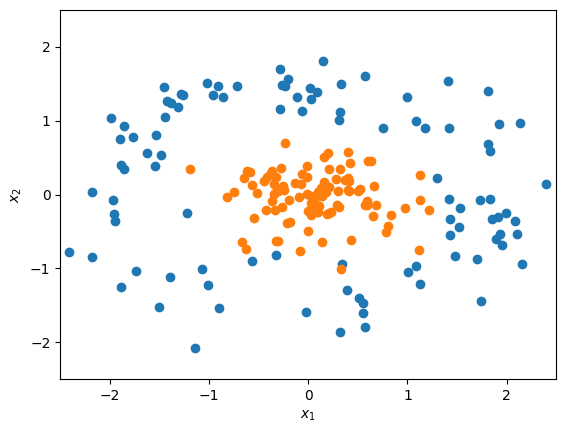

In [ ]:
# Sample data for test and training
X_train, y_train = get_dataset()
X_test, y_test = get_dataset()

# Plot training data
plot_data(X_train,y_train)

The two classes are not linearly separable. As we have seen, we cannot find a meaningful solution with logistic regression. Fortunately, our MLP can work well also when the input features are not separable. In particular, MLP learns a transformation that makes our input features linearly separable. On top of the transform features, we apply a standard logistic regression classifier.


# 2. **Numpy Implementation**

We can start from the implementation with NumPy. Numpy provides full flexibility but does not support automatic differentiation. This means that we have to code ourselves all the computations from getting the gradients.

As a first step, we define the activation functions and their gradients:

In [ ]:
def sigmoid(x):
    y = 1 / (1 + np.exp(-x))
    return y

def relu(x):
    return np.maximum(x, 0)

def step(x):
    return np.heaviside(x,0)

We also define the *binary cross-entropy* metric that will be useful to monitor the performance of the system and draw a learning curve at the end of training.

In [ ]:
def binary_cross_entropy(y_hat,y):
    """Computes the binary-corss entropy given the predictions and
    the labels."""
    bce = y * np.log(y_hat) + (1-y) * (np.log(1-y_hat))
    return -bce.mean()

We can now define the MLP model. The model is a class composed of three methods:
1. **\_\_init\_\_** initializes the parameters to learn with small random numbers.
2. **forward** that returns the output of the MLP model.
3. **backward** that computes the gradients using backpropagation.

You can find the equations of the gradient above.

In [ ]:
class MLP:
    def __init__(self, inputsize=2, neurons=32):
        "Initialization of the parameters (with small numbers)"
        W1 = np.random.rand(inputsize, neurons)*0.02 - 0.01
        W2 = np.random.rand(neurons,1)*0.02 - 0.01
        b1 = np.zeros(neurons)
        b2 = np.zeros(1)
        self.params = [W1, W2, b1, b2]

    def forward(self, X):
        "Returns the output of the MLP model"
        W1, W2, b1, b2 = self.params
        Z1 = relu(X @ W1 + b1)     # Layer 1
        Z2 = sigmoid(Z1 @ W2 +b2)  # Layer 2 (output)
        self.hidden = (Z1, Z2)     # Keep these for backprop
        return Z2

    def backward(self, Y):
        "Returns the gradients"
        W1, W2, b1,b2 = self.params
        Z1, Z2 = self.hidden
        D2 = Z2 - Y                       # Deltas for layer 2 (output)
        D1 = step(Z1) * (D2 @ W2.T)  # Deltas for layer 1

        # Gradients over parametes
        W2_grad = Z1.T @ D2         # Gradient for W2
        W1_grad = X.T @ D1          # Gradient for W1
        b2_grad = D2.sum(axis=0)    # Gradient for b2
        b1_grad = D1.sum(axis=0)    # Gradient for b1

        return W1_grad, W2_grad, b1_grad, b2_grad

Now, everything is ready to run the *training loop*.

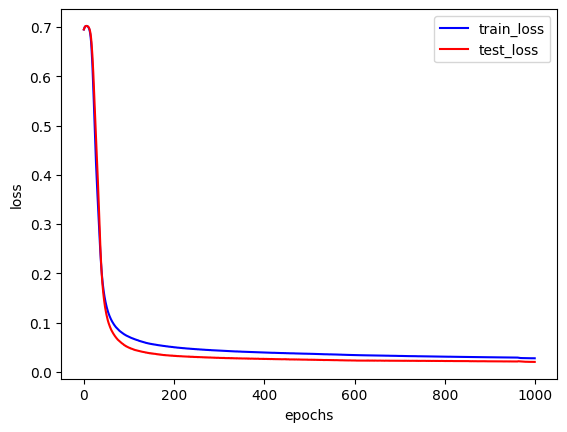

In [ ]:
# Hparams definition
num_epoch=1000
batch_size = 100
lr=0.01

# Model initialization
mlp = MLP(inputsize=X_train.shape[1], neurons=32)

# Training and test losses after each iteration
train_losses = []
test_losses = []

for epoch in range(1, num_epoch + 1):

    for i in range(0, len(X_train), batch_size):

        # minibath extraction
        X = X_train[i:i+batch_size]
        y = y_train[i:i+batch_size]

        probs = mlp.forward(X)     # Forward propagation
        grads = mlp.backward(y)    # Backward propagation

        # Parameter updates
        for i in range(len(mlp.params)):
          mlp.params[i] = mlp.params[i] - lr * grads[i]

    # Monitoring train and test losses
    probs = mlp.forward(X_train)
    tr_loss = binary_cross_entropy(probs,y_train)
    train_losses.append(tr_loss)

    probs = mlp.forward(X_test)
    te_loss = binary_cross_entropy(probs,y_test)
    test_losses.append(te_loss)


# Plot the training curve
plt.plot(train_losses, color='blue')
plt.plot(test_losses, color='red')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train_loss','test_loss'])
plt.show()


We can also visualize the decision boundaries of the learning classification function. We can do it with the following function:

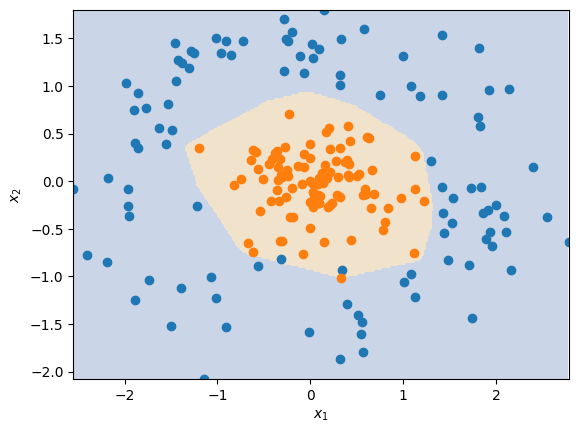

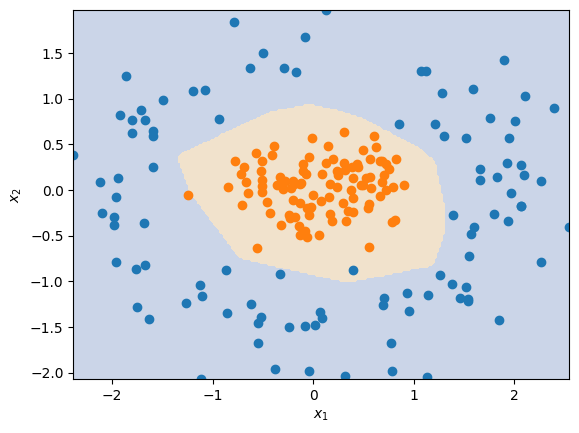

In [ ]:
def plot_boundaries(X, Y, model, h = 0.02):
    """Plots the data with the decision boundaries"""

    # create a mesh to plot in
    x1min = X[:,0].min()
    x1max = X[:,0].max()
    x2min = X[:,1].min()
    x2max = X[:,1].max()

    xx1, xx2 = np.meshgrid(np.arange(x1min, x1max, h), np.arange(x2min, x2max, h))
    X_grid = np.vstack([xx1.ravel(),xx2.ravel()]).T

    if isinstance(model,torch.nn.modules.container.Sequential):
      X_grid = torch.from_numpy(X_grid).float()
      probs = model(X_grid)
      probs = probs.detach().numpy()
    else:
      probs = model(X_grid)
    y_pred_grid = probs  > 0.5
    y_pred_grid = y_pred_grid.reshape(xx1.shape)
    cs = plt.contourf(xx1, xx2, y_pred_grid, cmap=plt.cm.Pastel2)

    plot_data(X,Y, xmin=x1min, xmax=x1max,  ymin =x2min, ymax = x2max)
    plt.show()

plot_boundaries(X_train,y_train, mlp.forward)
plot_boundaries(X_test,y_test, mlp.forward)

At the end of the training, the two classes are classified accurately on both training and test sets.

As you might have noticed, computing the gradient is a challenging and error-prone procedure. This is even worse when working with very deep models.

Fortunately, most of the deep learning toolkit uses *automatic differentiation*, which helps us with all the gradient computations. In the following, we are trying to implement the same model with PyTorch.

# 3. **PyTorch Implementation**
With PyTorch, there are no worries about gradient computation. Each basic operation has already defined a backward method with its gradient computation.
We can create arbitrarily complex pipelines of computations just by combining these basic operations and the gradient will be automatically computed.

First of all, we define the basic modules used for training our MLP:
- The model itself can be implemented in different ways in PyTorch. If it is a flat pipeline of computations, we can use the *Sequential* container whose use is pretty intuitive.

- Binary Cross-Entropy loss is natively implemented in Pytorch in `torch.nn.BCELoss()`

- Pytorch also natively implements the most popular optimizers used in deep learning. In this case, we use a simple SGD one.

In [ ]:
torch.manual_seed(0) # Ensure model weights initialized with same random numbers

# Create a neural network
model = torch.nn.Sequential(
    torch.nn.Linear(2, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 1),
    torch.nn.Sigmoid(),
)

# Create an object that can compute the binary cross-entropy
loss = torch.nn.BCELoss()

# Use stochastic gradient descent to train the model
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)


Now that the basic components are initialized, we can start the training loop:

In [ ]:
# Use 100 training samples at a time to compute the gradient.
batch_size = 100
num_epoch = 1000

# Converting data from numpy to pytorch
X_train_pt = torch.from_numpy(X_train).float()
y_train_pt = torch.from_numpy(y_train).float()

X_test_pt = torch.from_numpy(X_test).float()
y_test_pt = torch.from_numpy(y_test).float()

for epoch in range(1, num_epoch+1):

    # Make an entire pass (an 'epoch') over the training data in batch_size chunks
    for i in range(0, len(X_train), batch_size):
        X = X_train_pt[i:i+batch_size]     # Slice out a mini-batch of features
        y = y_train_pt[i:i+batch_size]     # Slice out a mini-batch of targets

        y_pred = model(X)                   # Make predictions (final-layer activations)
        l = loss(y_pred, y)                 # Compute loss with respect to predictions

        model.zero_grad()                   # Reset all gradient accumulators to zero (PyTorch thing)
        l.backward()                        # Compute gradient of loss wrt all parameters (backprop!)
        optimizer.step()                    # Use the gradients to take a step with SGD.

    print("Epoch %2d: loss on final training batch: %.4f" % (epoch, l.item()))

print("Epoch %2d: loss on test set: %.4f" % (epoch, loss(model(X_test_pt), y_test_pt)))


Epoch  1: loss on final training batch: 0.7364
Epoch  2: loss on final training batch: 0.7370
Epoch  3: loss on final training batch: 0.7375
Epoch  4: loss on final training batch: 0.7381
Epoch  5: loss on final training batch: 0.7385
Epoch  6: loss on final training batch: 0.7390
Epoch  7: loss on final training batch: 0.7394
Epoch  8: loss on final training batch: 0.7397
Epoch  9: loss on final training batch: 0.7400
Epoch 10: loss on final training batch: 0.7403
Epoch 11: loss on final training batch: 0.7406
Epoch 12: loss on final training batch: 0.7408
Epoch 13: loss on final training batch: 0.7410
Epoch 14: loss on final training batch: 0.7412
Epoch 15: loss on final training batch: 0.7413
Epoch 16: loss on final training batch: 0.7414
Epoch 17: loss on final training batch: 0.7415
Epoch 18: loss on final training batch: 0.7416
Epoch 19: loss on final training batch: 0.7416
Epoch 20: loss on final training batch: 0.7416
Epoch 21: loss on final training batch: 0.7416
Epoch 22: los

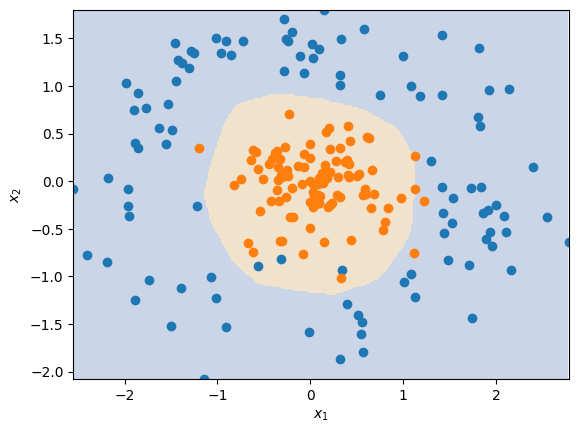

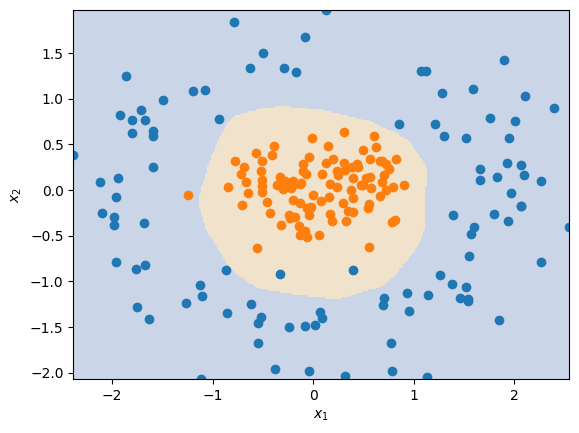

In [ ]:
plot_boundaries(X_train,y_train, model)
plot_boundaries(X_test,y_test, model)

We implemented our model with just a few lines of code. This is possible because we do not have to write the challenging, annoying, and boilerplate code for gradient computation. Moreover, many common modules used in deep learning are already implemented, helping us a lot to implement the desired functionality quickly and minimizing the risk of adding bugs to our code.

In the following, we will show how to use Scikit-learn for implementing an MLP.

# 4. **Scikit-learn implementation**

Scikit learn is an amazing tool for machine learning. It helps everyone to use machine learning models. In this case, we can run an MLP on our data with the following lines:

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(32), activation='relu',
                    solver='sgd', batch_size=100, max_iter=1000,
                    learning_rate_init=.01, momentum=0.9,
                    verbose=True, random_state=0)

mlp.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.80522521
Iteration 2, loss = 0.79713224
Iteration 3, loss = 0.78685059
Iteration 4, loss = 0.77376827
Iteration 5, loss = 0.75997562
Iteration 6, loss = 0.74623011
Iteration 7, loss = 0.73243802
Iteration 8, loss = 0.71974146
Iteration 9, loss = 0.70935229
Iteration 10, loss = 0.69856995
Iteration 11, loss = 0.68980294
Iteration 12, loss = 0.68233505
Iteration 13, loss = 0.67397840
Iteration 14, loss = 0.66753886
Iteration 15, loss = 0.66130802
Iteration 16, loss = 0.65527508
Iteration 17, loss = 0.64991565
Iteration 18, loss = 0.64437147
Iteration 19, loss = 0.63926878
Iteration 20, loss = 0.63422940
Iteration 21, loss = 0.62931636
Iteration 22, loss = 0.62451851
Iteration 23, loss = 0.61939516
Iteration 24, loss = 0.61468720
Iteration 25, loss = 0.60962074
Iteration 26, loss = 0.60481249
Iteration 27, loss = 0.60003922
Iteration 28, loss = 0.59514665
Iteration 29, loss = 0.59044841
Iteration 30, loss = 0.58547984
Iteration 31, loss = 0.58079487
Iteration 32, los

MLPClassifier(batch_size=100, hidden_layer_sizes=32, learning_rate_init=0.01,
              max_iter=1000, random_state=0, solver='sgd', verbose=True)

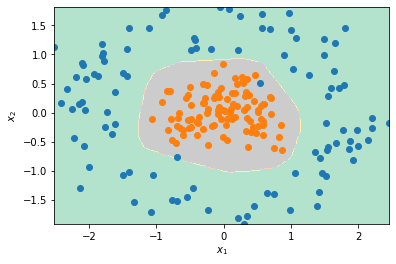

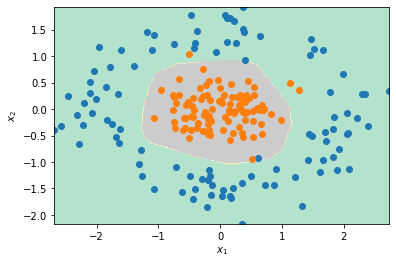

In [ ]:
plot_boundaries(X_train,y_train, mlp.predict)
plot_boundaries(X_test,y_test,mlp.predict)

Despite its simplicity, Scikit-learn is almost a "black box" that exposes some important hyperparameters of the model. This might be extremely useful for a beginner, but it is an important limitation for those practitioners that want to modify the model or implement a new one.

# **Conclusion**
We have implemented an MLP with three different libraries: NumPy, PyTorch, and Scikit-learn.

In the following table, a comparison of their features is provided:

| Library       | Pros                                                                                              | Cons                                                        |
|---------------|---------------------------------------------------------------------------------------------------|-------------------------------------------------------------|
| **Numpy**         | + Full Flexibility                                                                                | - No support for automatic differentiation  <br> - No GPU support |
| **PyTorch**       | + Full Flexibility  <br> + Automatic Differentiation   <br> + GPU support  <br> + Build-in deep learning routines |                                                             |
| **Scikit-learn**  | + Easy to use                                                                                     | - Little flexibility - No GPU support                       |

Among the three options, PyTorch stands out as an excellent choice for deep learning. It holds the current lead in popularity, being widely adopted in both industry and academia.